In [16]:
# activate ASTRAL/era5, using packages
cd(joinpath(homedir(), "Projects/ASTRAL/era5/src")) # working directory is src
using Pkg; Pkg.activate("..")    # Project is era5

using NCDatasets
using PyPlot
using FiniteDifferences
using Dates
# using Plots

  Activating project at `~/Projects/ASTRAL/era5`


In [8]:
# read one file

ncfile = filter(x->contains(x,"69e_2023") && endswith(x,".nc"), readdir())[1]
ds = NCDataset(ncfile)

Dataset: xsct_69e_2023.nc
Group: /

Dimensions
   longitude = 1
   latitude = 137
   level = 37
   time = 61

Variables
  longitude   (1)
    Datatype:    Float32 (Float32)
    Dimensions:  longitude
    Attributes:
     units                = degrees_east
     long_name            = longitude

  latitude   (137)
    Datatype:    Float32 (Float32)
    Dimensions:  latitude
    Attributes:
     units                = degrees_north
     long_name            = latitude

  level   (37)
    Datatype:    Int32 (Int32)
    Dimensions:  level
    Attributes:
     units                = millibars
     long_name            = pressure_level

  time   (61)
    Datatype:    Dates.DateTime (Int32)
    Dimensions:  time
    Attributes:
     units                = hours since 1900-01-01 00:00:00.0
     long_name            = time
     calendar             = gregorian

  d   (1 × 137 × 37 × 61)
    Datatype:    Union{Missing, Float64} (Int16)
    Dimensions:  longitude × latitude × level × time
    Att

In [9]:
# try unicodeplots
#= unicodeplots()
contour(ds["vo"][1,:,:,31])
=#
# not great for contours!

# matplotlib()

In [17]:
ds[:time]

time (61)
  Datatype:    DateTime (Int32)
  Dimensions:  time
  Attributes:
   units                = hours since 1900-01-01 00:00:00.0
   long_name            = time
   calendar             = gregorian


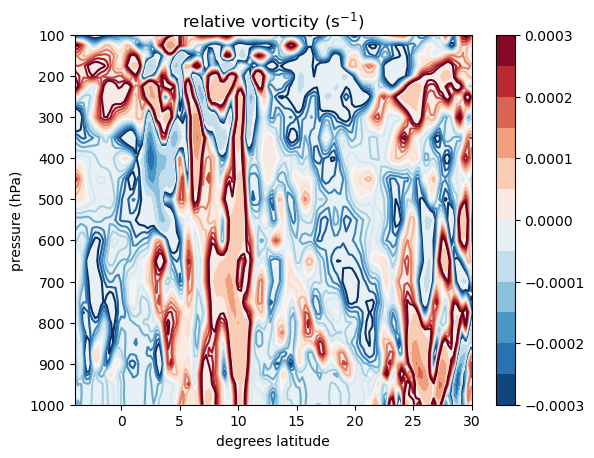

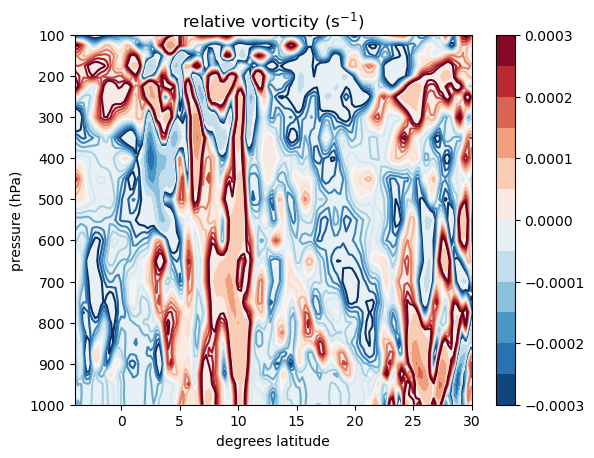

In [11]:
# try pyplot from Plots
#=
pyplot()
contourf(ds[:vo][1,:,:,31+4], 
    cmap = cgrad(:vik25),
    axis = ( font(12, "Times"), )) # doesn't know fonts
=#
# Plots complicates complicated PyPlot grammar

pd = permutedims
clf()
contourf(ds[:latitude][:], ds[:level][:],
    pd(ds[:vo][1,:,:,31+4]), 
    cmap=ColorMap("RdBu_r"), 
    # vmin=-3e-4, vmax=3e-4, 
    levels=1e-4*(-3:0.5:3) )
colorbar()
ylim([1000,100])
xlabel("degrees latitude")
ylabel("pressure (hPa)")
title("relative vorticity (s"*L"^{-1}"*")")
gcf()


In [36]:
# finite differences for arrays

const æ = 6.37e6 # radius of earth

"deprecated meridional derivative. ∂y(u) has same size as u"
function ∂y_old(u, y=ds[:latitude][:])
    # u = ds[:u][1,:,:,:] # eliminate singleton dim
    du = diff(u, dims=1)
    dy = æ * pi/180 * ([0; diff(y,dims=1)] .+ [diff(y,dims=1); 0])
    uy = zeros(size(u))
    uy[1:end-1,:,:] .= du
    uy[2:end,:,:] .+= du
    uy ./ dy
end

"""
Evaluate the vectorized operation f() along dimension dim of array x
looping over all other dimensions.
"""
function loopopdim(f, dim::Integer, x::AbstractArray)
    s = similar(x)
    Rpre = CartesianIndices(size(x)[1:dim-1])
    Rpost = CartesianIndices(size(x)[dim+1:end])
    _loopopdim!(f, s, x, Rpre, size(x, dim), Rpost)
end

function _loopopdim!(f, s, x, Rpre, n, Rpost)
    for Ipost in Rpost
        for Ipre in Rpre
            s[Ipre, :, Ipost] .= f( x[Ipre, :, Ipost] )
        end
    end
    s
end

"1st-order centered finite difference, padding end points with uncentered differences."
fdpad(x::Vector) = [ x[2]-x[1]; x[3:end].-x[1:end-2]; x[end]-x[end-1] ]

function ∂y(u=ds[:u][1,:,:,:], y=ds[:latitude][:])
    du =              loopopdim(fdpad, 1, u) 
    dy = æ * pi/180 * loopopdim(fdpad, 1, y)
    du ./ dy
end

∂y (generic function with 3 methods)

In [42]:
"""
Evaluate the vectorized operation f(x,y) along dimension dim of array x
that matches vector y; looping over all other dimensions.
"""
function loopopdim(f, dim::Integer, x::AbstractArray, y::Vector)
    s = similar(x)
    Rpre = CartesianIndices(size(x)[1:dim-1])
    Rpost = CartesianIndices(size(x)[dim+1:end])
    _loopopdim!(f, s, x, Rpre, size(x, dim), Rpost, y)
end

function _loopopdim!(f, s, x, Rpre, n, Rpost, y)
    for Ipost in Rpost
        for Ipre in Rpre
            s[Ipre, :, Ipost] .= f( x[Ipre, :, Ipost], y )
        end
    end
    s
end

_loopopdim! (generic function with 2 methods)

In [54]:
# compute the finite differences
dlnTdy = ∂y( log.(ds[:t][1,:,:,:]) )
dudy = ∂y( ds[:u][1,:,:,:] )
dvdx = ds[:vo][1,:,:,:] .+ dudy

# compare old and new methods
maximum(abs, ∂y_old( ds[:u][1,:,:,:] ) .- dudy ) # tiny, 10^-19

1.0842021724855044e-19

In [49]:
# ∂logT/∂logp

function ∂lnp(t=log.(ds[:t][1,:,:,:]), p=ds[:level][:])
    dlnT = loopopdim(fdpad, 2, t)
    dlnp = loopopdim(fdpad, 1, log.(p))
    # dlnTdlnp = loopopdim(./, 2, dlnT, dlnp ) # broadcast /dlnp along 2d dim of dlnT
    # mapslices of a broadcasting function !! yay !!
    dTdlnp = mapslices(x->x./dlnp, dlnT, dims=2)
end

dlnTdlnp = ∂lnp( log.(ds[:t][1,:,:,:]) )

137×37×61 Array{Float64, 3}:
[:, :, 1] =
  0.00168162   -0.0179212  -0.0795899  …  0.191117  0.191198  0.18969
  0.0037321    -0.0181717  -0.0796986     0.195133  0.187578  0.185132
  0.00519636   -0.0183406  -0.0800209     0.188786  0.192935  0.193267
  0.00594408   -0.0183918  -0.0806225     0.197526  0.190774  0.191218
  0.00607278   -0.0184441  -0.0814098     0.207499  0.190911  0.186545
  0.00584309   -0.0186393  -0.0822086  …  0.190272  0.19123   0.192719
  0.00546168   -0.0190006  -0.082833      0.183422  0.17316   0.191394
  0.00509182   -0.0193634  -0.0831996     0.186612  0.160894  0.179144
  0.00470138   -0.0194569  -0.0833095     0.19058   0.166609  0.183215
  0.0040953    -0.0190988  -0.0831804     0.189626  0.168835  0.185854
  0.00314287   -0.0182669  -0.0828378  …  0.180865  0.163398  0.177648
  0.00178886   -0.0171835  -0.0822037     0.184365  0.181025  0.203995
  0.000140986  -0.0162453  -0.0812544     0.191094  0.198338  0.228187
  ⋮                                  

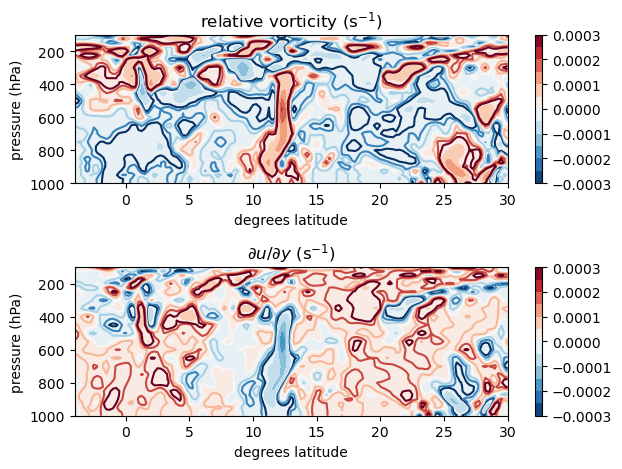

In [20]:
# plot vorticity and meridional shear of zonal velocity

it = findfirst(dt -> dt>=DateTime(2023,6,6,0,0,0), ds[:time][:] )

clf()
subplot(2,1,1)
contourf(ds[:latitude][:], ds[:level][:],
    pd(ds[:vo][1,:,:,it]), 
    cmap=ColorMap("RdBu_r"), 
    # vmin=-3e-4, vmax=3e-4, 
    levels=1e-4*(-3:0.5:3) )
colorbar()
contour(ds[:latitude][:], ds[:level][:],
    pd(ds[:vo][1,:,:,it]), 
    cmap=ColorMap("RdBu_r"), 
    # vmin=-3e-4, vmax=3e-4, 
    levels=1e-5*(-3:3) )
ylim([1000,100])
xlabel("degrees latitude")
ylabel("pressure (hPa)")
title("relative vorticity (s"*L"^{-1}"*")")

subplot(2,1,2)
contourf( ds[:latitude][:], ds[:level][:], 
    pd(dudy[:,:,it]),
   #vmin=-3e-4, vmax=3e-4,
    levels=1e-4.*(-3:0.5:3),
    cmap=ColorMap("RdBu_r"))
colorbar()
contour( ds[:latitude][:], ds[:level][:], 
    pd(dudy[:,:,it]),
    #vmin=-3e-4, vmax=3e-4,
    levels=1e-5.*(-3:3),
    cmap=ColorMap("RdBu_r"))
ylim([1000, 100])
xlabel("degrees latitude")
ylabel("pressure (hPa)")
title(L"\partial u/\partial y"*" (s"*L"^{-1}"*")")
tight_layout()
#gcf()

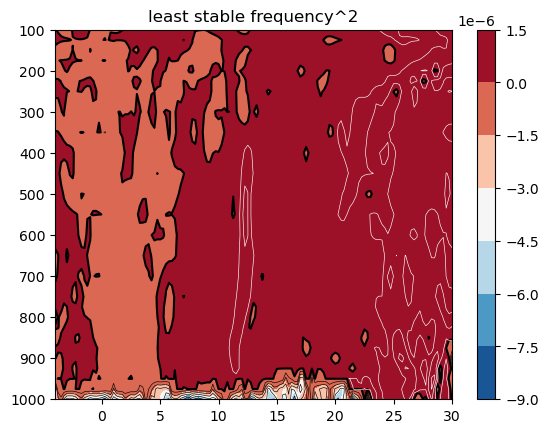

PyObject Text(0.5, 1.0, 'least stable frequency^2')

In [109]:
# characteristic frequencies for dry symmetric instability
# Bennetts and Hoskins 1979

# buoyancy frequency (squared)
const grav = 9.8 
const Rd = 287.0
const Cp = 1005.0
RdoCp = Rd/Cp
N² = @. grav^2 / (Rd*ds[:t][1,:,:,:]) * (RdoCp - dlnTdlnp) # s-2

# inertial frequency
const Ω = 7.2921159e-5 # s-1
fCoriolis(y) = 2*Ω*sind(y)
F2fcn(f, dudy) = f*(f-dudy)
F² = mapslices(dudy-> F2fcn.(fCoriolis.(ds[:latitude][:]), dudy), dudy, dims=1)

# thermal wind (shear)
S² = -grav * dlnTdy

# Ertel potential vorticity
q = @. F²*N² - S²*S²

σ_min² = @. ( N² + F² - sqrt((N² + F²)^2 - 4*q) )/2 # s^-1, +imaginary part indicates unstable growth
σ_unst = @. sqrt( Complex(σ_min²) ) # frequency of least stable symmetric mode

clf()
contourf(ds[:latitude][:], ds[:level][:], pd(σ_min²[:,:,it]),
    cmap=ColorMap("RdBu_r"))
colorbar()
contour(ds[:latitude][:], ds[:level][:], pd(σ_min²[:,:,it]),
    colors="k", levels=(0,))
contour(ds[:latitude][:], ds[:level][:], pd(imag.(σ_unst[:,:,it])),
    colors="k", linewidths=0.45, levels=0.5e-3:0.5e-3:3e-3)
contour(ds[:latitude][:], ds[:level][:], pd(real.(σ_unst[:,:,it])),
    colors="w", linewidths=0.45, levels=0.5e-4:0.25e-4:3e-4)
ylim([1000, 100])
title("least stable frequency^2")
# gcf()

In [98]:
1/.5e-3 / 60
# 6-30 h instability growth time scale

137×37×61 Array{ComplexF64, 3}:
[:, :, 1] =
 -9.53378+0.0im  -9.81473+0.0im     -9.83941+0.0im     …  -9.45298+0.0im
 -9.53729+0.0im   -9.8154+0.0im     -9.81134+0.0im        -9.48231+0.0im
 -9.54695+0.0im  -9.80872+0.0im     -9.78582+0.0im         -9.5129+0.0im
 -9.57227+0.0im  -9.80115+0.0im     -9.81669+0.0im        -9.62328+0.0im
 -9.60458+0.0im  -9.78185+0.0im     -9.85681+0.0im        -9.70723+0.0im
 -9.63553+0.0im  -9.75579+0.0im     -9.86472+0.0im     …  -9.73893+0.0im
 -9.65754+0.0im  -9.73597+0.0im     -9.84436+0.0im        -9.63481+0.0im
 -9.66461+0.0im  -9.72008+0.0im     -9.81713+0.0im        -9.54239+0.0im
 -9.65756+0.0im  -9.70231+0.0im     -9.79855+0.0im        -9.54336+0.0im
  -9.6447+0.0im  -9.68739+0.0im     -9.80345+0.0im        -9.60872+0.0im
 -9.63388+0.0im  -9.68268+0.0im     -9.83762+0.0im     …  -9.58764+0.0im
 -9.63128+0.0im  -9.69001+0.0im     -9.87708+0.0im        -9.71605+0.0im
 -9.64268+0.0im  -9.70447+0.0im     -9.88134+0.0im         -9.5796+0.0im
       

In [99]:
pi/2

1.5707963267948966